In [65]:
# Import the standard modules
import sqlite3

# Import installed modules
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [66]:
# Connect to the comet database. This database has been created in tutorial
# part 7, however, due to its small size the database is uploaded on GitHub
con = sqlite3.connect('../databases/comets/mpc_comets.db')

# Create a pandas dataframe that contains the perihelion and the absolute
# magnitude
comets_df = pd.read_sql('SELECT PERIHELION_AU, ABSOLUTE_MAGNITUDE ' \
                        'FROM comets_main WHERE ECCENTRICITY < 1', \
                        con)

In [67]:
# Print some descriptive statistics
print('Descriptive Statistics of the Absolute Magnitude of Comets')
print(f'{comets_df["ABSOLUTE_MAGNITUDE"].describe()}')

Descriptive Statistics of the Absolute Magnitude of Comets
count    1083.000000
mean       12.398615
std         3.630675
min         1.000000
25%         9.500000
50%        12.500000
75%        15.000000
max        27.000000
Name: ABSOLUTE_MAGNITUDE, dtype: float64


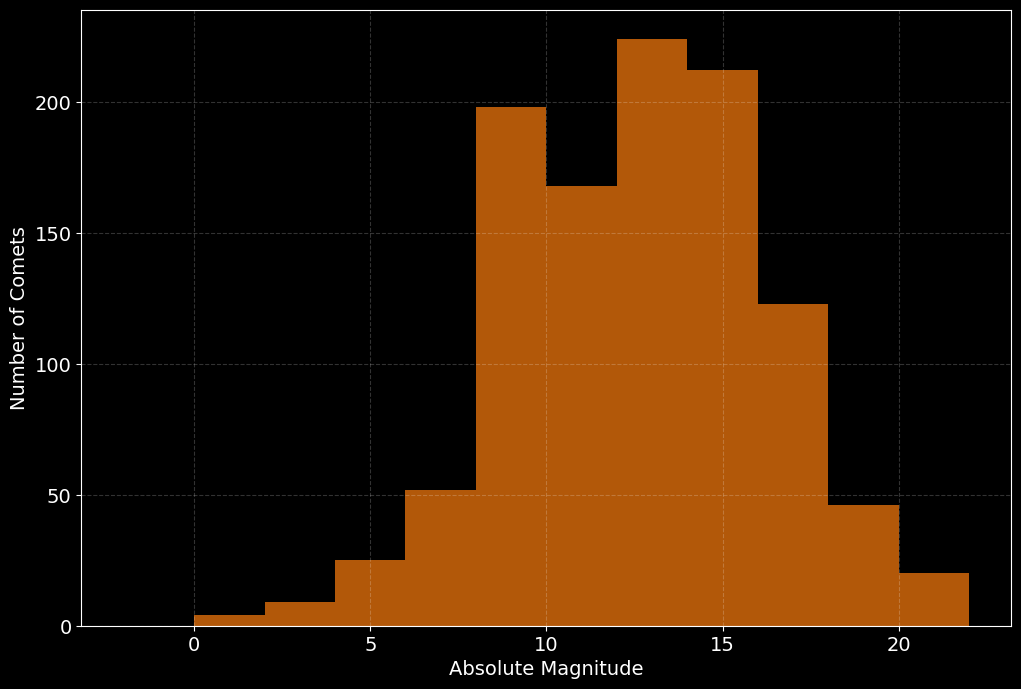

In [68]:
# Define a histogram bins array
bins_range = np.arange(-2, 22 + 2, 2)

# Let's set a dark background
plt.style.use('dark_background')

# Set a default font size for better readability
plt.rcParams.update({'font.size': 14})

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot a histogram of the absolute magnitude distribution
ax.hist(comets_df['ABSOLUTE_MAGNITUDE'], bins=bins_range, color='tab:orange', \
        alpha=0.7)

# Set labels for the x and y axes
ax.set_xlabel('Absolute Magnitude')
ax.set_ylabel('Number of Comets')

# Set a grid
ax.grid(axis='both', linestyle='dashed', alpha=0.2)

# Save the figure
plt.savefig('comets_abs_mag_hist.png', dpi=300)

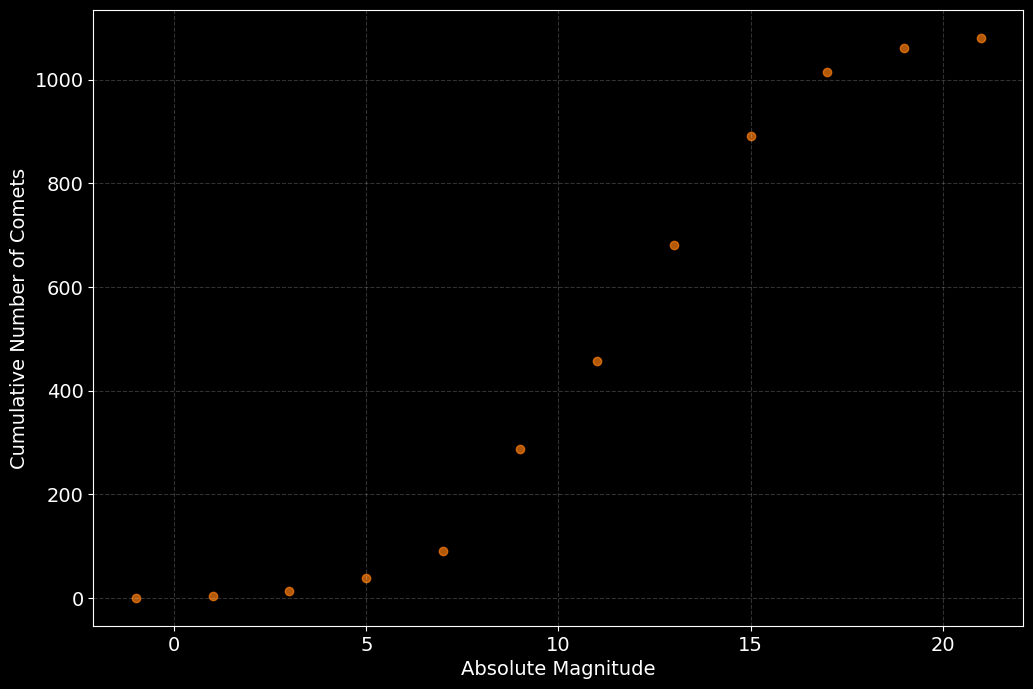

In [69]:
# The histogram provides a simple overview of the distribution of the
# Absolute Magnitudes ... what does it imply? Are there really, only a few
# smaller comets in the Solar System?

# Let's create a cumulative histogram as a scatter plot for a better
# visibility of possible trends

# Compute a cumulative distribution of the absolute magnitude
abs_mag_hist, bins_edge = np.histogram(comets_df['ABSOLUTE_MAGNITUDE'], \
                                       bins=bins_range)
cumul_hist = np.cumsum(abs_mag_hist)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Create a scatter plot of the cumulative distribution. Consider, to shift the
# bin array by half of the bins' width
ax.scatter(bins_edge[:-1]+1, cumul_hist, color='tab:orange', alpha=0.7, \
           marker='o')

# Set labels for the x and y axes
ax.set_xlabel('Absolute Magnitude')
ax.set_ylabel('Cumulative Number of Comets')

# Set a grid
ax.grid(axis='both', linestyle='dashed', alpha=0.2)

# Save the figure
plt.savefig('comets_abs_mag_cumul_hist.png', dpi=300)

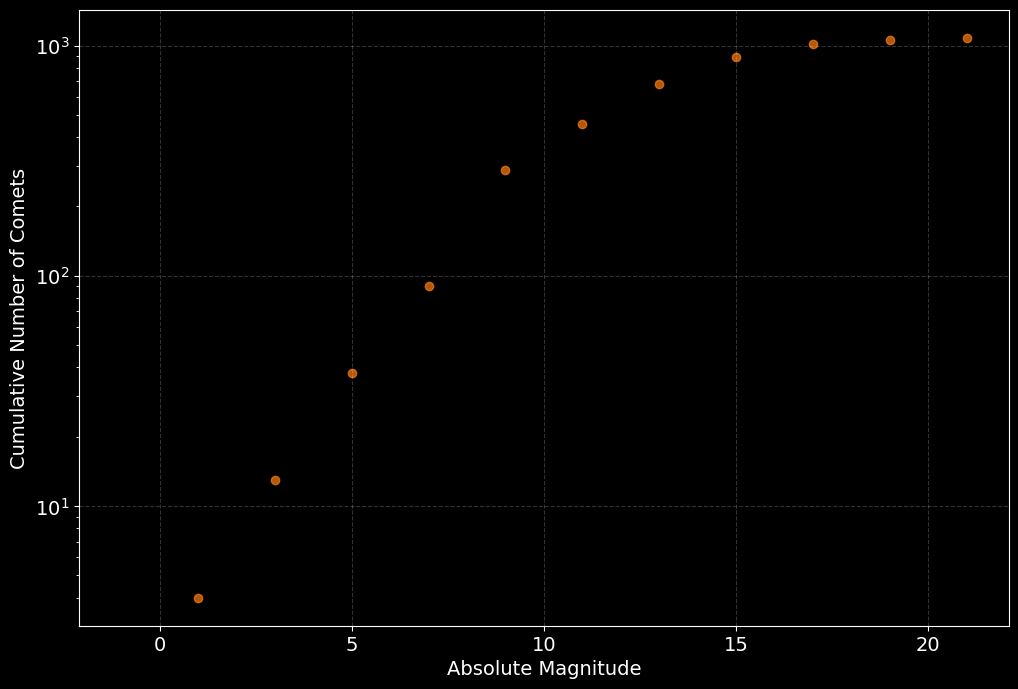

In [70]:
# The plot ... does not help a lot ... what about a logarithmic scale?

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Create a scatter plot of the cumulative distribution.
ax.scatter(bins_edge[:-1]+1, cumul_hist, color='tab:orange', alpha=0.7, \
           marker='o')

# Set labels for the x and y axes
ax.set_xlabel('Absolute Magnitude')
ax.set_ylabel('Cumulative Number of Comets')

# Set a grid
ax.grid(axis='both', linestyle='dashed', alpha=0.2)

# Set a logarithmic y axis
ax.set_yscale('log')

plt.savefig('comets_abs_mag_log10cumul_hist.png', dpi=300)

In [71]:
# The logarithmic plots appears to be promising. Let's assume that we know all
# larger comets; we use the first 5 data points to create a linear regression
# model in semi-log space

# Create two arrays that contain the abs. mag. for the fitting and plotting
# routine
abs_mag_fit = bins_edge[:5]+1
abs_mag_plot = bins_edge[:-1]+1

# Get the first 5 cumulative results
cumul_fit = cumul_hist[:5]

# Replace any zero or negative values with a small epsilon to avoid -inf or NaN in log10
epsilon = np.finfo(float).eps
cumul_fit_safe = np.where(cumul_fit <= 0, epsilon, cumul_fit)

# Import the linear model from scikit-learn
from sklearn import linear_model
reg = linear_model.LinearRegression()

# Fit the linear regression model with the data
reg.fit(abs_mag_fit.reshape(-1, 1), np.log10(cumul_fit_safe))

# Compute a linear plot for the entire abs. mag. range
cumulative_abs_mag_pred = reg.predict(abs_mag_plot.reshape(-1, 1))

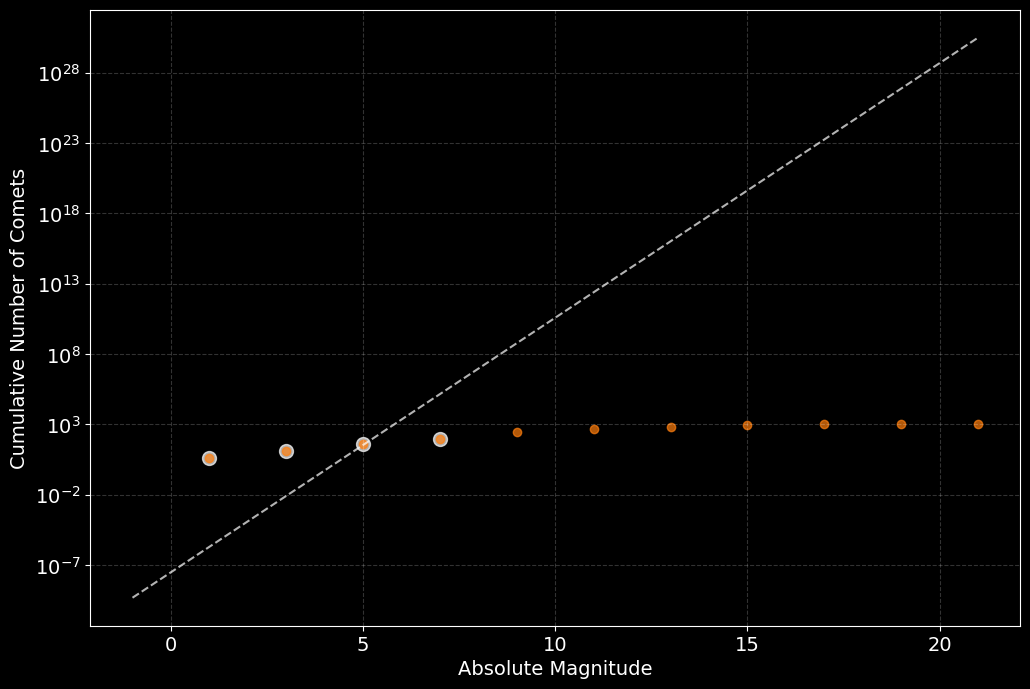

In [72]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the used data points as white dots and ...
ax.scatter(abs_mag_fit, cumul_fit, color='white', alpha=0.7, marker='o', \
           s=100)

# ... plot also the complete data set
ax.scatter(bins_edge[:-1]+1, cumul_hist, color='tab:orange', alpha=0.7, \
           marker='o')

# Plot the linear regression.
ax.plot(abs_mag_plot, 10**cumulative_abs_mag_pred, 'w--', alpha=0.7)

# Set labels for the x and y axes as well as a grid
ax.set_xlabel('Absolute Magnitude')
ax.set_ylabel('Cumulative Number of Comets')
ax.grid(axis='both', linestyle='dashed', alpha=0.2)

# Set a log y scale
ax.set_yscale('log')

# Save the figure
plt.savefig('comets_abs_mag_log10cumul_hist_linreg.png', dpi=300)

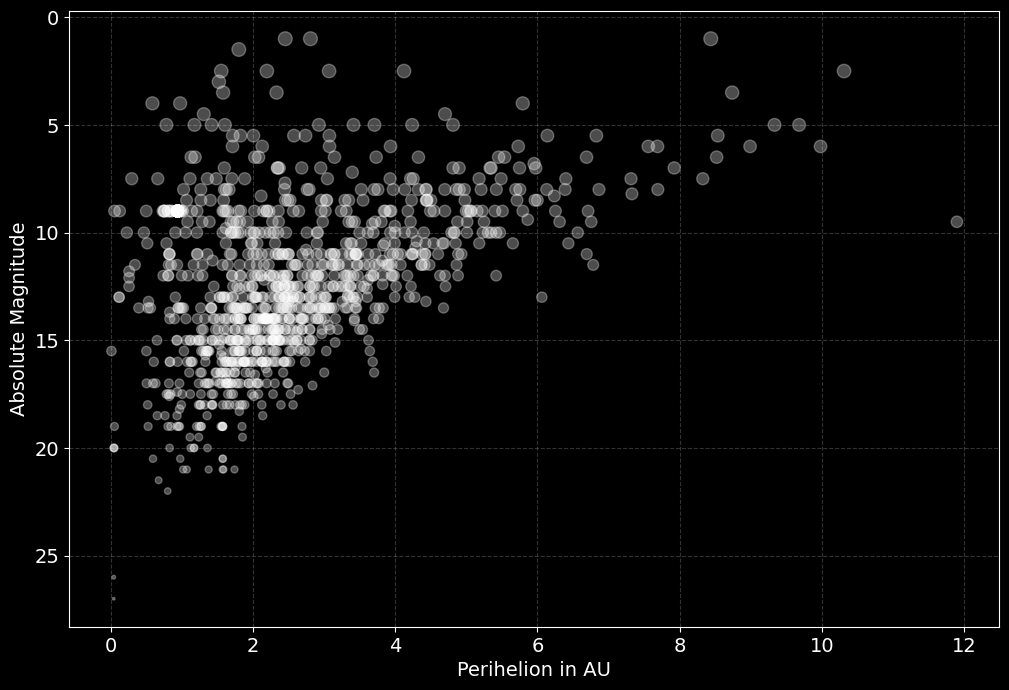

In [73]:
# Let's see wether we find a dependency between the perihelion and the abs.
# mag.
fig, ax = plt.subplots(figsize=(12, 8))

# To visualise the relation between abs. mag. and size better, we scale the
# scatter plot dot size w.r.t. to the abs. mag.
# A large abs. mag. corresponds to a small size. First, subtract the values
# by the maximum and subtract 1 (otherwise the largest value will become 0)
comet_size_plot = abs(comets_df['ABSOLUTE_MAGNITUDE'] \
                      - comets_df['ABSOLUTE_MAGNITUDE'].max() - 1)

# Second and third, normalise the results and scale them by a factor of 100
comet_size_plot /= max(comet_size_plot)
comet_size_plot *= 100

# Create a scatter plot of the perihelion vs. the abs. mag. with the marker
# sizing
ax.scatter(comets_df['PERIHELION_AU'], comets_df['ABSOLUTE_MAGNITUDE'], \
           color='white', s=comet_size_plot, alpha=0.3)

# Invert the y axis to create a graph that is similar to the logic of the
# Malmquist Bias shown in the article
ax.invert_yaxis()

# Set labels and a grid
ax.set_xlabel('Perihelion in AU')
ax.set_ylabel('Absolute Magnitude')
ax.grid(axis='both', linestyle='dashed', alpha=0.2)

# Save the figure
plt.savefig('comets_abs_mag_vs_perih.png', dpi=300)